In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Load the data
df = pd.read_csv('Fragrance Dataset - COM7022 - [4037].csv')

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nColumns info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (1000, 10)

First few rows:
            brand                                              title  \
0            Dior  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...   
1         AS SHOW  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...   
2       Unbranded                   HOGO BOSS cologne For Men 3.4 oz   
3  Giorgio Armani  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...   
4         Lattafa  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...   

              type   price priceWithCurrency  available  \
0    Eau de Parfum   84.99      US $84.99/ea       10.0   
1    Eau de Parfum  109.99        US $109.99        8.0   
2  Eau de Toilette  100.00        US $100.00       10.0   
3  Eau de Toilette     NaN      US $44.99/ea        2.0   
4       Fragrances   16.91         US $16.91        NaN   

                           availableText   sold                lastUpdated  \
0      More than 10 available / 116 sold  116.0  May 24, 2024 10:03:04 PDT   
1            

In [27]:
# Data cleaning and preprocessing
def preprocess_data(df):
    # Create a copy
    data = df.copy()
    
    # Handle missing values in price
    data['price'] = pd.to_numeric(data['price'], errors='coerce')
    
    # Extract numeric price from priceWithCurrency where price is missing
    def extract_price(price_str):
        if pd.isna(price_str):
            return np.nan
        try:
            # Remove currency and convert to float
            return float(str(price_str).replace('US $', '').replace('/ea', '').split('/')[0])
        except:
            return np.nan
    
    # Fill missing prices
    mask = data['price'].isna()
    data.loc[mask, 'price'] = data.loc[mask, 'priceWithCurrency'].apply(extract_price)
    
    # Handle remaining missing prices with median
    data['price'] = data['price'].fillna(data['price'].median())
    
    # Clean sold column - remove commas and convert to numeric
    data['sold'] = pd.to_numeric(data['sold'].astype(str).str.replace(',', ''), errors='coerce')
    data['sold'] = data['sold'].fillna(0)
    
    # Clean available column
    data['available'] = pd.to_numeric(data['available'], errors='coerce')
    data['available'] = data['available'].fillna(0)
    
    # Feature engineering
    # 1. Popularity ratio
    data['popularity_ratio'] = data['sold'] / (data['available'] + 1)
    
    # 2. Log transformation of price
    data['log_price'] = np.log1p(data['price'])
    
    # 3. Brand frequency
    brand_freq = data['brand'].value_counts().to_dict()
    data['brand_frequency'] = data['brand'].map(brand_freq)
    
    # 4. Type intensity mapping
    type_intensity = {
        'Parfum': 5,
        'LE PARFUM': 5,
        'Eau de Parfum': 4,
        'Eau De Parfum': 4,
        'Eau de Parfum Intense': 4.5,
        'Eau de Parfum Spray': 4,
        'Eau de Toilette': 3,
        'Eau De Toilette': 3,
        'Eau de Cologne': 2,
        'Eau de Cologne Spray': 2,
        'Cologne': 2,
        'Perfume': 3,
        'Fragrances': 3,
        'Body Spray': 1,
        'Aftershave': 1,
        'Deodorant': 1,
        'Unscented': 0,
        'Pheromone': 2,
        'Concentrated Uncut Pure Body Oil': 2,
        'Extrait De Parfum': 5,
        'Extrait de Parfum': 5,
        'Roll On': 2,
        'Fragrance Rolling Ball': 2,
        'Gift Sets': 3
    }
    
    data['type_intensity'] = data['type'].map(type_intensity).fillna(3)  # Default to medium intensity
    
    # 5. Simplify location to country
    def extract_country(location):
        if pd.isna(location):
            return 'Unknown'
        location_str = str(location).lower()
        if 'united states' in location_str or 'usa' in location_str:
            return 'USA'
        elif 'canada' in location_str:
            return 'Canada'
        elif 'china' in location_str:
            return 'China'
        elif 'hong kong' in location_str:
            return 'Hong Kong'
        elif 'taiwan' in location_str:
            return 'Taiwan'
        else:
            return 'Other'
    
    data['country'] = data['itemLocation'].apply(extract_country)
    
    # 6. Price segments
    def price_segment(price):
        if price < 20:
            return 'Budget'
        elif price < 50:
            return 'Mid-range'
        elif price < 100:
            return 'Premium'
        else:
            return 'Luxury'
    
    data['price_segment'] = data['price'].apply(price_segment)
    
    return data

# Preprocess the data
processed_data = preprocess_data(df)

print("Processed data overview:")
print(f"Total records: {len(processed_data)}")
print(f"Features created: popularity_ratio, log_price, brand_frequency, type_intensity, country, price_segment")
print("\nSample of processed data:")
print(processed_data[['brand', 'price', 'sold', 'available', 'popularity_ratio', 'type_intensity']].head(10))

Processed data overview:
Total records: 1000
Features created: popularity_ratio, log_price, brand_frequency, type_intensity, country, price_segment

Sample of processed data:
             brand   price   sold  available  popularity_ratio  type_intensity
0             Dior   84.99  116.0       10.0         10.545455             4.0
1          AS SHOW  109.99   48.0        8.0          5.333333             4.0
2        Unbranded  100.00   27.0       10.0          2.454545             3.0
3   Giorgio Armani   44.99  159.0        2.0         53.000000             3.0
4          Lattafa   16.91  156.0        0.0        156.000000             3.0
5  Multiple Brands   14.99   79.0       10.0          7.181818             3.0
6  Maison Alhambra   30.99   39.0        9.0          3.900000             4.0
7        Unbranded   85.00    6.0        0.0          6.000000             4.0
8        Unbranded   15.89   17.0       10.0          1.545455             3.0
9            Gucci   49.99   68.0  

In [28]:
# Select features for clustering
clustering_features = ['price', 'sold', 'available', 'popularity_ratio', 'log_price', 'brand_frequency', 'type_intensity']

# Create feature matrix
X = processed_data[clustering_features].copy()

# Handle any remaining missing values
X = X.fillna(X.median())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X_scaled.shape)
print("Features used for clustering:", clustering_features)

Feature matrix shape: (1000, 7)
Features used for clustering: ['price', 'sold', 'available', 'popularity_ratio', 'log_price', 'brand_frequency', 'type_intensity']


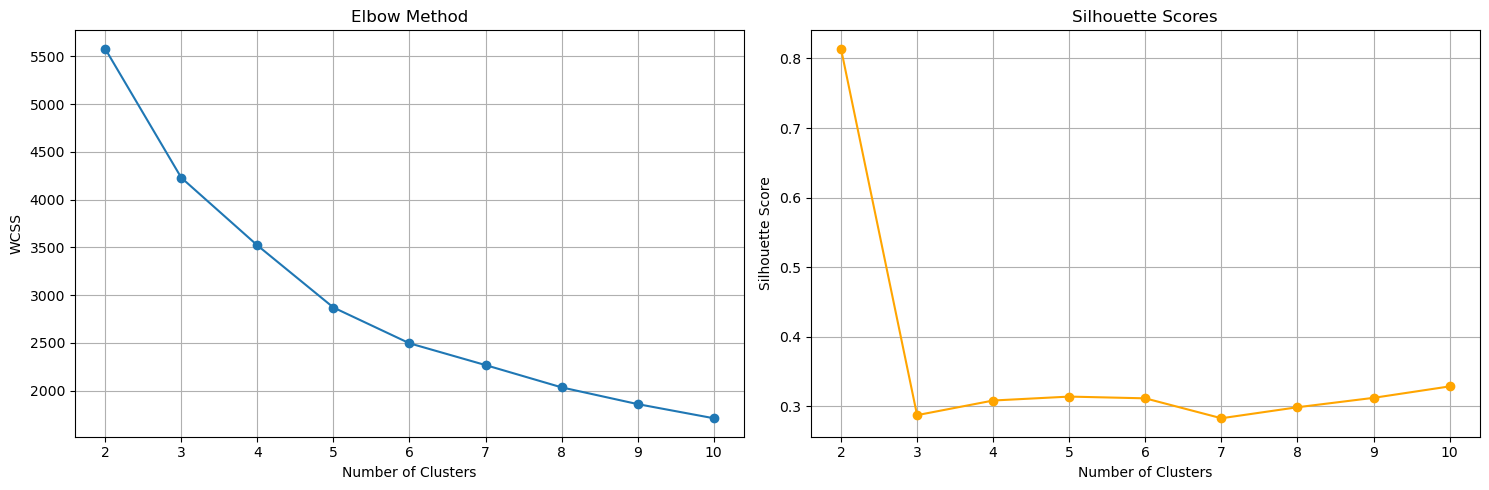

Optimal number of clusters based on silhouette score: 2


In [29]:
# Determine optimal number of clusters using elbow method and silhouette score
def find_optimal_clusters(X, max_k=10):
    wcss = []  # Within-cluster sum of squares
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        
        # Calculate silhouette score
        labels = kmeans.labels_
        if len(set(labels)) > 1:  # Need at least 2 clusters for silhouette score
            silhouette_scores.append(silhouette_score(X, labels))
        else:
            silhouette_scores.append(0)
    
    return wcss, silhouette_scores

wcss, silhouette_scores = find_optimal_clusters(X_scaled)

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
ax1.plot(range(2, 11), wcss, marker='o')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS')
ax1.set_title('Elbow Method')
ax1.grid(True)

# Silhouette scores
ax2.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Scores')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = np.argmax(silhouette_scores) + 2
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

In [30]:
# Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataset
processed_data['cluster'] = cluster_labels

# Calculate clustering metrics
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
db_index = davies_bouldin_score(X_scaled, cluster_labels)

print(f"Clustering Results (K={optimal_k}):")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Cluster distribution:")
print(processed_data['cluster'].value_counts().sort_index())

Clustering Results (K=2):
Silhouette Score: 0.814
Davies-Bouldin Index: 0.410
Cluster distribution:
cluster
0    994
1      6
Name: count, dtype: int64


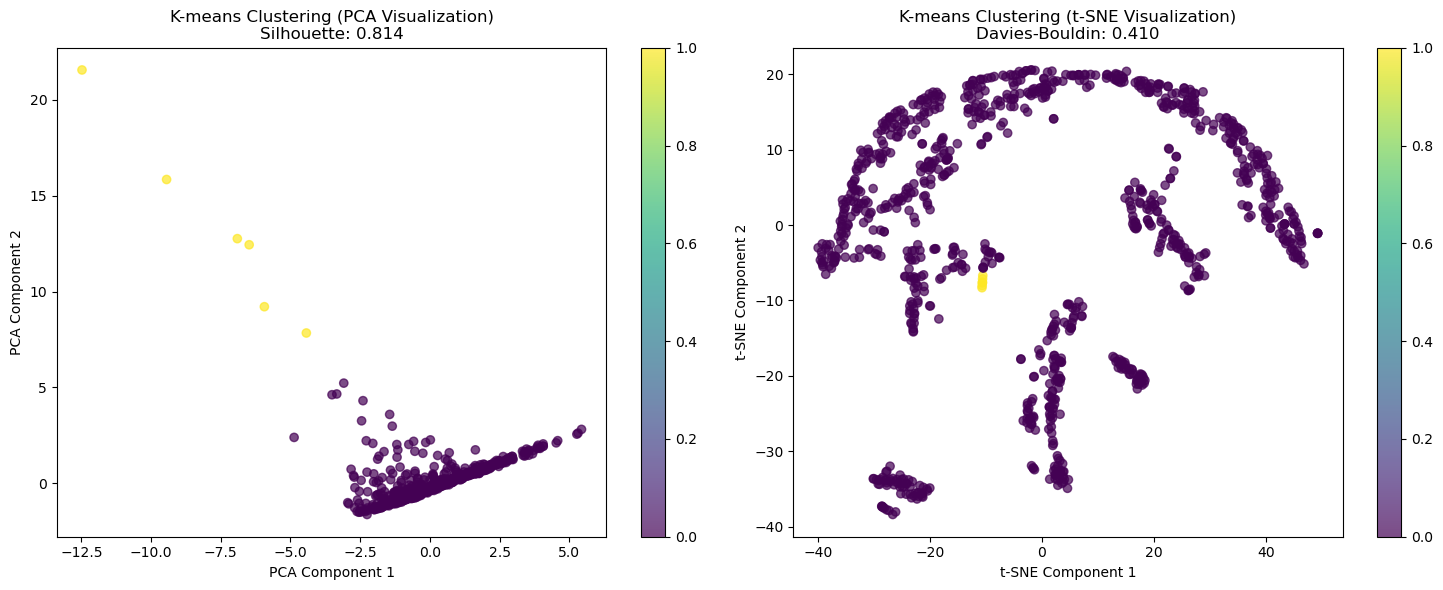

PCA Explained Variance: [0.31072366 0.26236007]
Total Variance Explained: 0.573


In [32]:
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# PCA visualization
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_title(f'K-means Clustering (PCA Visualization)\nSilhouette: {silhouette_avg:.3f}')
plt.colorbar(scatter1, ax=ax1)

# t-SNE visualization
scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.set_title(f'K-means Clustering (t-SNE Visualization)\nDavies-Bouldin: {db_index:.3f}')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

# Print PCA explained variance
print(f"PCA Explained Variance: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.3f}")

In [33]:
# Analyze cluster characteristics
cluster_analysis = processed_data.groupby('cluster')[clustering_features].agg(['mean', 'std']).round(2)
print("Cluster Characteristics:")
print(cluster_analysis)

# Brand distribution across clusters
brand_cluster = pd.crosstab(processed_data['cluster'], processed_data['brand'])
print("\nTop brands in each cluster:")
for cluster in range(optimal_k):
    top_brands = brand_cluster.loc[cluster].nlargest(3)
    print(f"Cluster {cluster}: {', '.join([f'{brand}({count})' for brand, count in top_brands.items()])}")

# Price segment distribution
price_segment_dist = pd.crosstab(processed_data['cluster'], processed_data['price_segment'], normalize='index')
print("\nPrice Segment Distribution by Cluster:")
print(price_segment_dist.round(3))

# Type distribution
type_dist = pd.crosstab(processed_data['cluster'], processed_data['type'], normalize='index')
print("\nTop fragrance types by cluster:")
for cluster in range(optimal_k):
    top_types = type_dist.loc[cluster].nlargest(2)
    print(f"Cluster {cluster}: {', '.join([f'{type_}({pct:.1%})' for type_, pct in top_types.items()])}")

Cluster Characteristics:
         price             sold           available        popularity_ratio  \
          mean    std      mean       std      mean    std             mean   
cluster                                                                       
0        46.56  35.61    564.55   1735.03     17.93  58.53           187.36   
1        32.61   9.70  33417.00  12262.93      0.00   0.00         33417.00   

                  log_price       brand_frequency        type_intensity        
              std      mean   std            mean    std           mean   std  
cluster                                                                        
0         1018.09      3.63  0.67           16.98  17.45           3.25  0.65  
1        12262.93      3.48  0.29           16.00   4.82           3.00  0.00  

Top brands in each cluster:
Cluster 0: Giorgio Armani(60), Paco Rabanne(45), Ralph Lauren(41)
Cluster 1: Calvin Klein(2), Versace(2), Azzaro(1)

Price Segment Distribution by Clu

In [34]:
# Compare different clustering algorithms
algorithms = {
    'K-means': KMeans(n_clusters=optimal_k, random_state=42, n_init=10),
    'Agglomerative': AgglomerativeClustering(n_clusters=optimal_k),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
}

results = {}

for name, algorithm in algorithms.items():
    if name == 'DBSCAN':
        labels = algorithm.fit_predict(X_scaled)
        # DBSCAN might create noise points (label = -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    else:
        labels = algorithm.fit_predict(X_scaled)
        n_clusters = optimal_k
    
    if n_clusters > 1:
        silhouette = silhouette_score(X_scaled, labels)
        db_index = davies_bouldin_score(X_scaled, labels)
    else:
        silhouette = -1
        db_index = float('inf')
    
    results[name] = {
        'labels': labels,
        'silhouette': silhouette,
        'db_index': db_index,
        'n_clusters': n_clusters
    }
    
    print(f"{name}:")
    print(f"  Clusters: {n_clusters}")
    print(f"  Silhouette: {silhouette:.3f}")
    print(f"  Davies-Bouldin: {db_index:.3f}")
    print(f"  Cluster distribution: {pd.Series(labels).value_counts().to_dict()}")
    print()

K-means:
  Clusters: 2
  Silhouette: 0.814
  Davies-Bouldin: 0.410
  Cluster distribution: {0: 994, 1: 6}

Agglomerative:
  Clusters: 2
  Silhouette: 0.838
  Davies-Bouldin: 0.323
  Cluster distribution: {0: 996, 1: 4}

DBSCAN:
  Clusters: 12
  Silhouette: 0.105
  Davies-Bouldin: 1.765
  Cluster distribution: {2: 352, 0: 188, -1: 187, 4: 103, 3: 47, 7: 47, 1: 36, 6: 10, 5: 7, 11: 7, 8: 6, 9: 5, 10: 5}



Cluster Profiles:
 Cluster  Size  Avg_Price     Avg_Sold  Avg_Popularity_Ratio  Avg_Type_Intensity      Top_Brand        Top_Type Price_Segment
       0   994   46.56493   564.554326            187.361332            3.251006 Giorgio Armani Eau de Toilette     Mid-range
       1     6   32.61000 33417.000000          33417.000000            3.000000   Calvin Klein Eau de Toilette     Mid-range


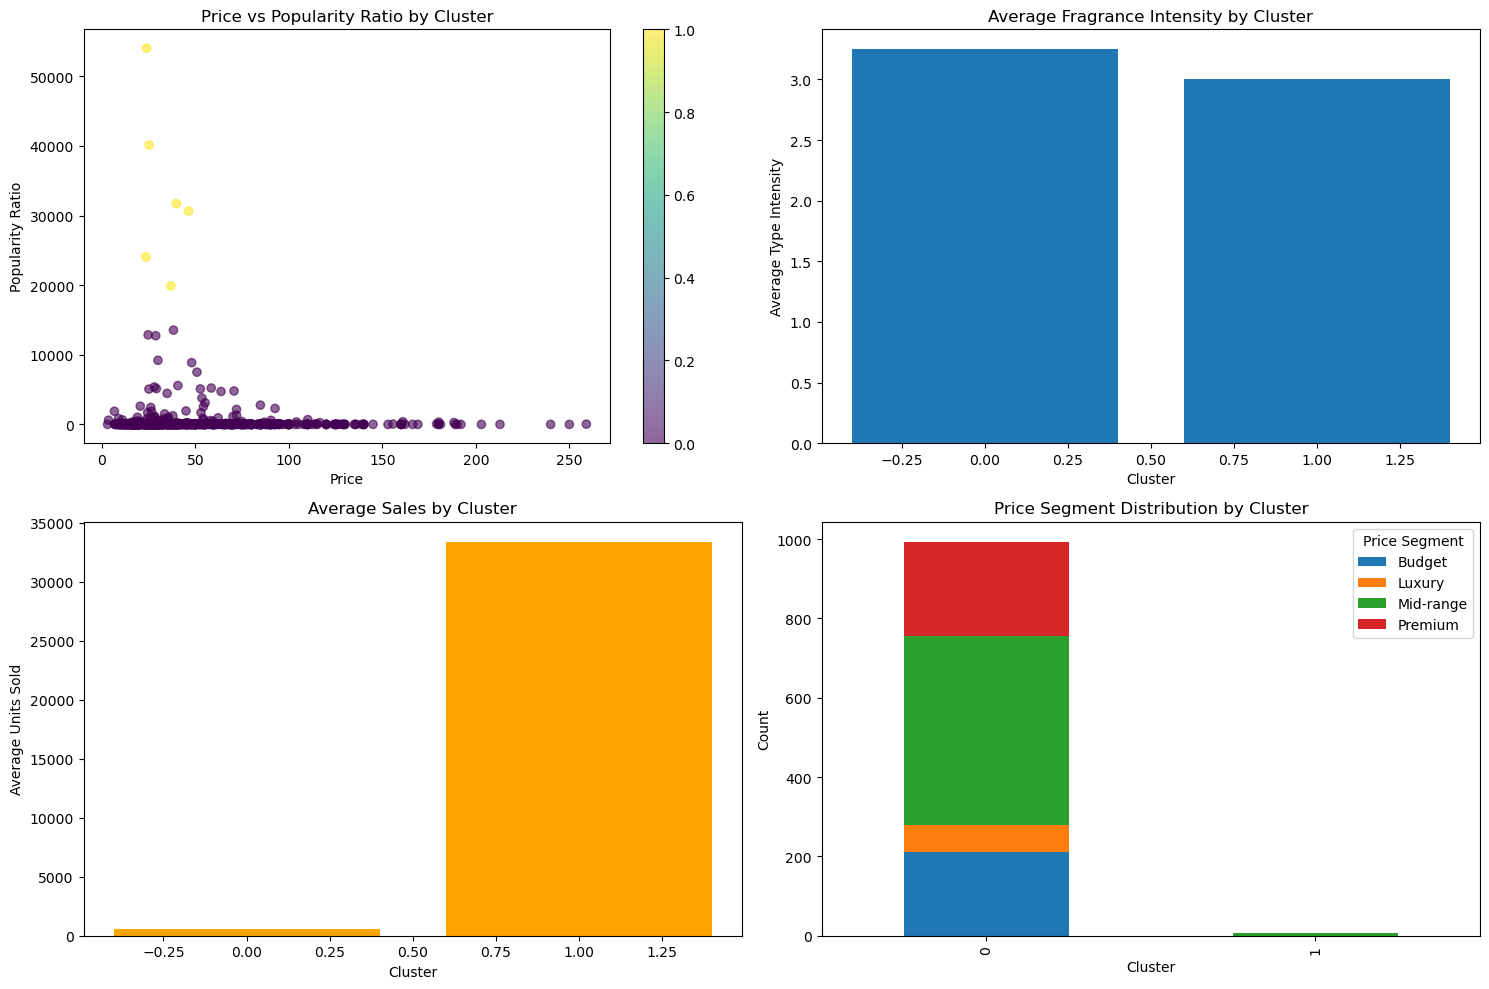


Clustered data saved to 'fragrance_data_clustered.csv'


In [35]:
# Create cluster profiles
def create_cluster_profiles(data, clusters, features):
    profiles = []
    
    for cluster_id in range(clusters):
        cluster_data = data[data['cluster'] == cluster_id]
        
        profile = {
            'Cluster': cluster_id,
            'Size': len(cluster_data),
            'Avg_Price': cluster_data['price'].mean(),
            'Avg_Sold': cluster_data['sold'].mean(),
            'Avg_Popularity_Ratio': cluster_data['popularity_ratio'].mean(),
            'Avg_Type_Intensity': cluster_data['type_intensity'].mean(),
            'Top_Brand': cluster_data['brand'].mode().iloc[0] if not cluster_data['brand'].mode().empty else 'Unknown',
            'Top_Type': cluster_data['type'].mode().iloc[0] if not cluster_data['type'].mode().empty else 'Unknown',
            'Price_Segment': cluster_data['price_segment'].mode().iloc[0] if not cluster_data['price_segment'].mode().empty else 'Unknown'
        }
        
        profiles.append(profile)
    
    return pd.DataFrame(profiles)

# Generate cluster profiles
cluster_profiles = create_cluster_profiles(processed_data, optimal_k, clustering_features)
print("Cluster Profiles:")
print(cluster_profiles.to_string(index=False))

# Visualize cluster profiles
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price vs Popularity
scatter = axes[0,0].scatter(processed_data['price'], processed_data['popularity_ratio'], 
                           c=processed_data['cluster'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Price')
axes[0,0].set_ylabel('Popularity Ratio')
axes[0,0].set_title('Price vs Popularity Ratio by Cluster')
plt.colorbar(scatter, ax=axes[0,0])

# Type intensity distribution
type_intensity_by_cluster = processed_data.groupby('cluster')['type_intensity'].mean()
axes[0,1].bar(type_intensity_by_cluster.index, type_intensity_by_cluster.values)
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Average Type Intensity')
axes[0,1].set_title('Average Fragrance Intensity by Cluster')

# Sales distribution
sold_by_cluster = processed_data.groupby('cluster')['sold'].mean()
axes[1,0].bar(sold_by_cluster.index, sold_by_cluster.values, color='orange')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Average Units Sold')
axes[1,0].set_title('Average Sales by Cluster')

# Price segment distribution
price_segment_counts = processed_data.groupby(['cluster', 'price_segment']).size().unstack(fill_value=0)
price_segment_counts.plot(kind='bar', stacked=True, ax=axes[1,1])
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Price Segment Distribution by Cluster')
axes[1,1].legend(title='Price Segment')

plt.tight_layout()
plt.show()

# Save the clustered data
processed_data.to_csv('fragrance_data_clustered.csv', index=False)
print("\nClustered data saved to 'fragrance_data_clustered.csv'")